<a href="https://colab.research.google.com/github/AumMule/Product-Card-Design/blob/main/My_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📋 Columns: ['City', 'Country', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8019 - loss: 0.4456 - val_accuracy: 0.9762 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9635 - loss: 0.0795 - val_accuracy: 0.9836 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9777 - loss: 0.0551 - val_accuracy: 0.9885 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.0494 - val_accuracy: 0.9803 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9842 - loss: 0.0400 - val_accuracy: 0.9951 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9855 - loss: 0.0344 - val_accuracy: 0.9877 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0287 - 

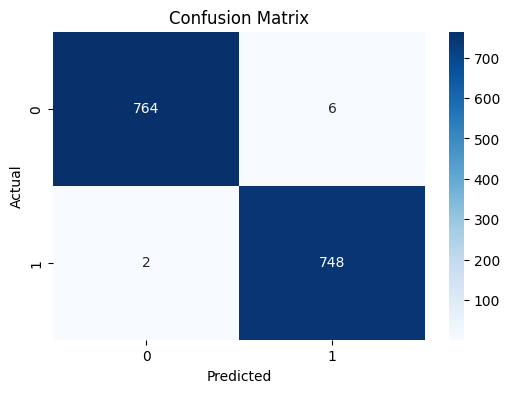

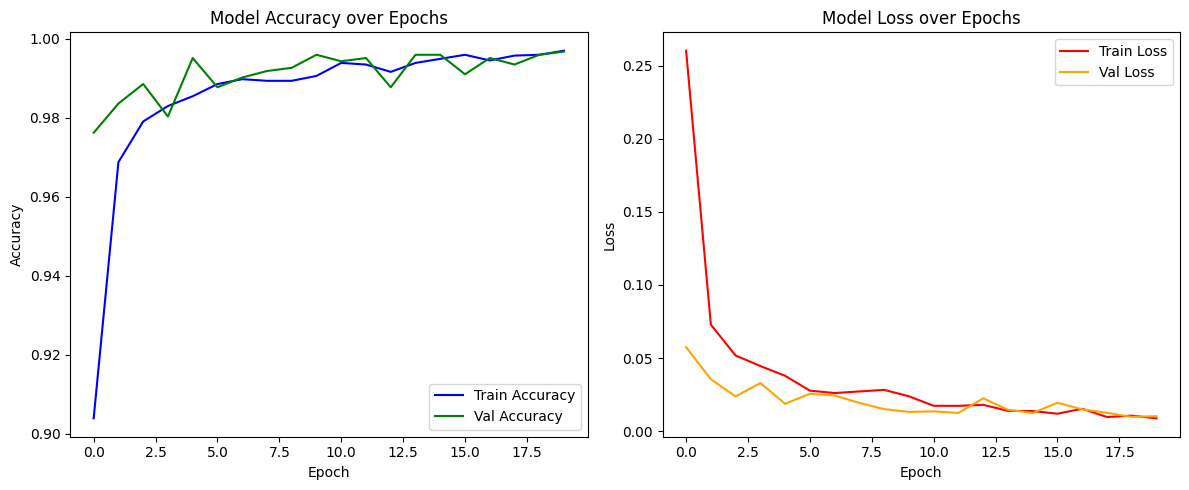

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

df = pd.read_csv('global_air_quality_data_10000.csv')

print("📋 Columns:", df.columns.tolist())

df.dropna(inplace=True)

df['Label'] = df['PM2.5'].apply(lambda x: 1 if x >= 60 else 0)

selected_features = ['PM2.5', 'Temperature', 'Humidity', 'PM10', 'CO', 'NO2', 'SO2']
for col in selected_features:
    if col not in df.columns:
        raise ValueError(f"Missing column in dataset: {col}")

df_full = df[selected_features + ['Label']]
safe = df_full[df_full['Label'] == 0]
hazardous = df_full[df_full['Label'] == 1]

hazardous_upsampled = resample(hazardous, replace=True, n_samples=len(safe), random_state=42)
df_balanced = pd.concat([safe, hazardous_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

X = df_balanced[selected_features]
y = df_balanced['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n✅ Final Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
